In [4]:
import sys

import pandas as pd
import json
import dask
from dask import delayed, compute
dask.config.set(scheduler='threads')

import main

In [6]:
config_path = 'config_postprocessing.json'

In [3]:
main.main(config_path)

Loading input data... (2025-08-19 10:35:51)
Saving merged mitgcm results... (2025-08-19 10:35:57)
Detecting eddies and creating level 0 catalogue... (2025-08-19 10:36:04)
...using 9 cores...
Saving catalogue level 0 to ./outputs/eddy_catalogues_lvl0/lvl0_20230808_20230808.csv... (2025-08-19 10:40:44)
Done. (2025-08-19 10:40:45)


In [7]:
with open(config_path, 'r') as file:
    pp_config = json.load(file)

In [8]:
from functions.open_files_functions import load_input_data_binary

In [9]:
with open(config_path, 'r') as file:
    pp_config = json.load(file)

In [11]:
swirl_input_data = load_input_data_binary(pp_config['i_mitgcm_folder_path'],
                                         pp_config['binary_mitgcm_grid_folder_path'],
                                         pp_config['binary_ref_date'],
                                         pp_config['binary_dt'])

In [12]:
swirl_input_data.ds_mitgcm

<xarray.Dataset> Size: 4GB
Dimensions:  (XC: 336, YC: 132, XG: 336, YG: 132, Z: 100, Zp1: 101, Zu: 100,
              Zl: 100, time: 62)
Coordinates: (12/34)
  * XC       (XC) >f4 1kB 100.0 300.0 500.0 700.0 ... 6.67e+04 6.69e+04 6.71e+04
  * YC       (YC) >f4 528B 100.0 300.0 500.0 ... 2.59e+04 2.61e+04 2.63e+04
  * XG       (XG) >f4 1kB 0.0 200.0 400.0 600.0 ... 6.66e+04 6.68e+04 6.7e+04
  * YG       (YG) >f4 528B 0.0 200.0 400.0 600.0 ... 2.58e+04 2.6e+04 2.62e+04
  * Z        (Z) >f4 400B -0.25 -0.7575 -1.281 -1.82 ... -295.6 -305.2 -315.1
  * Zp1      (Zp1) >f4 404B 0.0 -0.5 -1.015 -1.546 ... -300.4 -310.1 -320.1
    ...       ...
    rhoRef   (Z) >f4 400B dask.array<chunksize=(100,), meta=np.ndarray>
    dyF      (YC, XC) >f4 177kB dask.array<chunksize=(132, 336), meta=np.ndarray>
    dxF      (YC, XC) >f4 177kB dask.array<chunksize=(132, 336), meta=np.ndarray>
    dxV      (YG, XG) >f4 177kB dask.array<chunksize=(132, 336), meta=np.ndarray>
    iter     (time) int64 496B dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) datetime64[ns] 496B 2023-08-08T00:10:08 ... 2023-08-08T10...
Data variables:
    UVEL     (time, Z, YC, XG) float32 1GB dask.array<chunksize=(1, 100, 132, 336), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) float32 1GB dask.array<chunksize=(1, 100, 132, 336), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) float32 1GB dask.array<chunksize=(1, 100, 132, 336), meta=np.ndarray>
    THETA    (time, Z, YC, XC) float32 1GB dask.array<chunksize=(1, 100, 132, 336), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(data_dir='/storage/alpl...

In [13]:
import numpy as np
import os
import netCDF4

In [14]:
class MitgcmGrid:
    """Class representing an MITgcm grid, with optional loading from .npy files."""

    def __init__(self):
        """Initialize an empty MITgcm grid."""
        self.x = np.array([])
        self.y = np.array([])
        self.lat_grid = np.array([])
        self.lon_grid = np.array([])
        self.dz = np.array([])
        self.parameters = {}

    def load_from_path(self, path_grid: str):
        """
        Load grid data from a given folder containing .npy files.

        Args:
            path_grid (str): Path to the folder containing the grid files.

        Raises:
            FileNotFoundError: If any required grid file is missing.
            RuntimeError: If loading fails due to other errors.
        """
        try:
            self.x = np.load(os.path.join(path_grid, 'x.npy'))
            self.y = np.load(os.path.join(path_grid, 'y.npy'))
            self.lat_grid = np.load(os.path.join(path_grid, 'lat_grid.npy'))
            self.lon_grid = np.load(os.path.join(path_grid, 'lon_grid.npy'))
            self.dz = pd.read_csv(os.path.join(path_grid, 'dz.csv'), header=None).to_numpy()
            with open(os.path.join(path_grid, 'parameters.json'), 'r') as file:
                self.parameters = json.load(file)
        except FileNotFoundError as e:
            raise FileNotFoundError(f"Missing grid file: {e.filename}") from e
        except Exception as e:
            raise RuntimeError(f"Error loading grid data: {e}") from e


def get_mitgcm_grid(path_folder_grid: str) -> MitgcmGrid:
    grid = MitgcmGrid()
    grid.load_from_path(path_folder_grid)
    return grid

In [108]:
def reformat_and_save_mitgcm_results(uvel, vvel, wvel, theta, times, depths, grid_folder, output_path, nodata=-999.0):
    grid = get_mitgcm_grid(os.path.join(grid_folder, "grid"))

    # Shift velocities to cell centers
    if uvel.shape == vvel.shape:
        uvel_shifted = np.pad(uvel[..., 1:], ((0,0),(0,0), (0,0), (0,1)), constant_values=0)
        vvel_shifted = np.pad(vvel[..., 1:, :], ((0,0),(0,0), (0,1), (0,0)), constant_values=0)
    else:
        uvel_shifted = uvel[..., 1:]
        vvel_shifted = vvel[..., 1:, :]
    uvel = (uvel + uvel_shifted) / 2
    vvel = (vvel + vvel_shifted) / 2

    w = wvel.copy()
    t = theta.copy()

    # Optional rotation
    if "rotation" in grid.parameters:
        print(f"Rotating u,v by {-grid.parameters['rotation']}°")
        theta_rad = np.deg2rad(-grid.parameters["rotation"])
        u = uvel * np.cos(theta_rad) - vvel * np.sin(theta_rad)
        v = uvel * np.sin(theta_rad) + vvel * np.cos(theta_rad)
    else:
        u, v = uvel, vvel

    # Apply nodata mask
    mask = (t == 0.0) | np.isnan(t)
    for arr in [t, w, u, v]:
        arr[mask] = nodata

    # Build dataset
    ds = xr.Dataset(
        {
            "t": (("time", "depth", "Y", "X"), t, {"units": "°C", "long_name": "Temperature"}),
            "u": (("time", "depth", "Y", "X"), u, {"units": "m/s", "long_name": "Eastward velocity"}),
            "v": (("time", "depth", "Y", "X"), v, {"units": "m/s", "long_name": "Northward velocity"}),
            "w": (("time", "depth", "Y", "X"), w, {"units": "m/s", "long_name": "Vertical velocity"}),
        },
        coords={
            "time": ("time", times, {"long_name": "time"}),
            "depth": ("depth", depths, {"units": "m", "long_name": "Depth below surface"}),
            "lat": (("Y", "X"), grid.lat_grid, {"long_name": "Latitude"}),
            "lng": (("Y", "X"), grid.lon_grid, {"long_name": "Longitude"}),
        },
        attrs={"MITgcm_version": "MITgcm-checkpoint67z"},
    )

    # Ensure NaN instead of nodata if you prefer CF-compliant missing values
    ds = ds.where(ds != nodata)

    # Save to NetCDF
    ds.to_netcdf(output_path, format="NETCDF4", encoding={
        "time": {"units": "seconds since 1970-01-01 00:00:00", "calendar": "standard"},
        "t": {"zlib": True, "complevel": 4, "_FillValue": nodata},
        "u": {"zlib": True, "complevel": 4, "_FillValue": nodata},
        "v": {"zlib": True, "complevel": 4, "_FillValue": nodata},
        "w": {"zlib": True, "complevel": 4, "_FillValue": nodata},
    })


In [110]:
grid_folder = "/storage/alplakes_test/geneva_200m/"
output_path = "./outputs/mitgcm_results/test4.nc"
reformat_and_save_mitgcm_results(swirl_input_data.uvel_data, swirl_input_data.vvel_data, swirl_input_data.wvel_data, swirl_input_data.theta_data, swirl_input_data.times, swirl_input_data.depths, grid_folder, output_path, nodata=-999.0)

Rotating u,v by -19.411486858683578°


In [97]:
import xarray as xr
import matplotlib.pyplot as plt

In [111]:
test = xr.open_dataset(output_path, decode_times=False)
test['time'] = xr.decode_cf(test[['time']])['time']

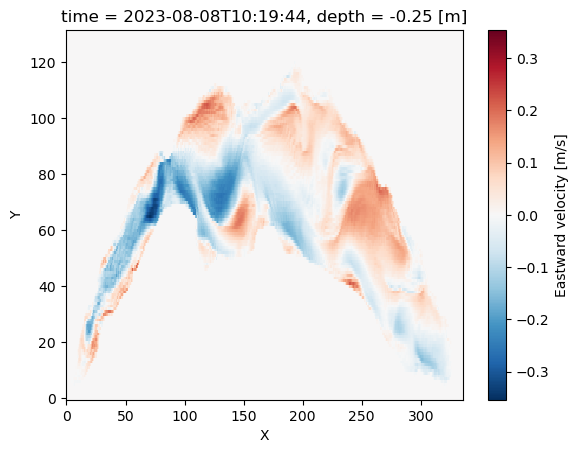

In [118]:
test.isel(time=-1, depth=0).u.plot()